# Import Packages

In [13]:
import os
import json
import math
import boto3
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from scipy.interpolate import interp1d

DATA_DIRECTORY = os.getcwd()
S3_BUCKET = 'article-data'
S3_FOLDER = 'around-the-world'

# Read Data

In [2]:
filepath = os.path.join(DATA_DIRECTORY, 'ETOPO1_Ice_g_geotiff.tif')
raster = rasterio.open(filepath)
raster_height = raster.read(1)
raster.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 21601, 'height': 10801, 'count': 1, 'crs': None, 'transform': Affine(0.016666666666666666, 0.0, -180.00833333333333,
       0.0, -0.016666666666666663, 90.00833333333334), 'tiled': False, 'interleave': 'band'}

# Examine Min/Max Data

In [3]:
max_height = np.amax(raster_height)
max_height_indices = np.where(raster_height == max_height)
max_height_lat_lon = raster.xy(max_height_indices[0][0], max_height_indices[1][0])

print("Max Height: ", max_height)

print("Lat Index: ", max_height_indices[1][0])
print("Lon Index: ", max_height_indices[0][0])

print("Lat: ", max_height_lat_lon[1])
print("Lon: ", max_height_lat_lon[0])

Max Height:  8271
Lat Index:  16016
Lon Index:  3721
Lat:  27.98333333333335
Lon:  86.93333333333334


In [4]:
min_height = np.amin(raster_height)
min_height_indices = np.where(raster_height == min_height)
min_height_lat_lon = raster.xy(min_height_indices[0][0], min_height_indices[1][0])

print("Min Height: ", min_height)

print("Lat Index: ", min_height_indices[1][0])
print("Lon Index: ", min_height_indices[0][0])

print("Lat: ", min_height_lat_lon[1])
print("Lon: ", min_height_lat_lon[0])

Min Height:  -10898
Lat Index:  19331
Lon Index:  4719
Lat:  11.350000000000023
Lon:  142.18333333333334


# Plot Data

In [25]:
def get_distances(index, raster, raster_height, previous_distance=0, previous_height=0, reverse=False):
    base = 1.8532513372265385 #km or 0.166666666666 degrees
    distances = []
    is_first = True
    indices = list(reversed(range(raster.height))) if reverse else range(raster.height)
    for i in indices:
        if is_first:
            adjustment = 0
            if reverse:
                prev_height = previous_height
                current_height = raster_height[i, index]
                adjustment = math.sqrt(base**2 + (prev_height-current_height)**2)
            distances.append(previous_distance + adjustment)
            is_first = False
        else:
            prev_distance = distances[indices[0] - i - 1] if reverse else distances[i - 1]
            prev_height = raster_height[i - 1, index]
            current_height = raster_height[i, index]
            
            distance = math.sqrt(base**2 + (prev_height-current_height)**2)
            distances.append(distance + prev_distance)
    return distances

def get_antipode_longitude(longitude):
    antipode_longitude = 180 - abs(longitude)
    if longitude > 0:
        antipode_longitude = -1 * antipode_longitude
    return antipode_longitude


def get_elevation_path(latitude, longitude, raster, raster_height, s3_client=None, should_plot=False, output_file=False):
    antipode_longitude = get_antipode_longitude(longitude)
    negative_longitude = antipode_longitude if longitude >= 0 else longitude
    positive_longitude = longitude if longitude >= 0 else antipode_longitude
    
    # Get the first part of the path (negative longitude)
    raster_index = raster.index(negative_longitude, latitude)
    lon_index = raster_index[1]
    distances = get_distances(lon_index, raster, raster_height)
    heights = [raster_height[i, lon_index] for i in range(raster.height)]
    
    # Get the other half of the path (positive longitude)
    inv_raster_index = raster.index(positive_longitude, -latitude)
    inv_lon_index = inv_raster_index[1]
    inv_distances = get_distances(inv_lon_index, raster, raster_height, previous_distance=distances[-1], previous_height=heights[-1], reverse=True)
    inv_heights = [raster_height[i, inv_lon_index] for i in range(raster.height)][::-1]
    
    # Combine the two paths
    combined_distances = distances + inv_distances
    combined_heights = heights + inv_heights
    
    
    if output_file:
        output_json = {
            "distance": [round(i) for i in combined_distances],
            "elevation": [int(i) for i in combined_heights],
        }
        output_filename = "{0}.json".format(lon_index)
        if s3_client is not None:
            print("Outputting file to s3 for index: {0}".format(lon_index))
            client.put_object(
                Body=bytes(json.dumps(output_json).encode('UTF-8')),
                Bucket=S3_BUCKET,
                Key='{0}/{1}'.format(S3_FOLDER, output_filename)
            )
        else:
            with open(output_filename, "w") as f:
                json.dump(output_json, f)

            
    if should_plot:
        lat_index = raster_index[0]
        inv_lat_index = inv_raster_index[0]
        reverse_lat_index = len(combined_heights) - lat_index - 1
        point_index = reverse_lat_index if longitude >= 0 else lat_index
        
        axes = plt.gca()
        # Mariana Trench is 11K+ meters deep!
        axes.set_ylim([-11000,11000])
        plt.plot(combined_heights)
        plt.plot(
#             [combined_distances[point_index]],
            point_index,
            [combined_heights[point_index]],
            marker='o',
            markersize=10,
            color="red"
        )
        
        latitudes = [raster.xy(i, lon_index)[1] for i in range(raster.height)]
        inv_latitudes = [raster.xy(i, inv_lon_index)[1] for i in range(raster.height)][::-1]
        combined_latitudes = latitudes + inv_latitudes
        
        return combined_distances, combined_latitudes, combined_heights, point_index
    
    
    return combined_distances, None, combined_heights, None

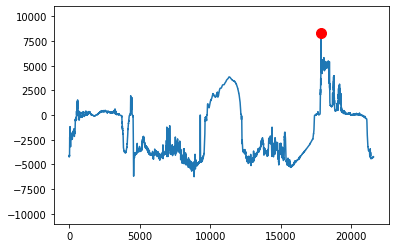

In [6]:
# Mt. Everest
lat = max_height_lat_lon[1]
lon = max_height_lat_lon[0]
d, l, h, i = get_elevation_path(lat, lon, raster, raster_height, should_plot=True)

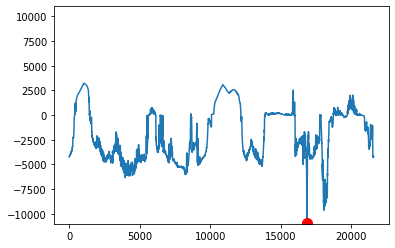

In [7]:
# Mariana Trench
lat = min_height_lat_lon[1]
lon = min_height_lat_lon[0]
d, l, h, i = get_elevation_path(lat, lon, raster, raster_height, should_plot=True)

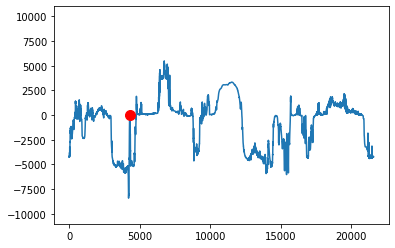

In [8]:
# Mayagüez
lat = 18.204498
lon = -67.126673
d, l, h, i = get_elevation_path(lat, lon, raster, raster_height, should_plot=True)

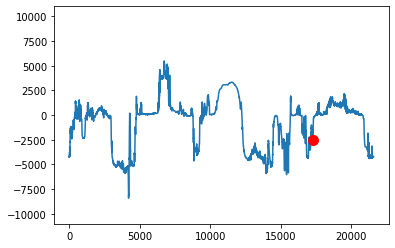

In [9]:
# Mayagüez's antipode
lat = 18.204498
lon = 112.873327
d, l, h, i = get_elevation_path(lat, lon, raster, raster_height, should_plot=True)

# Interpolation Example

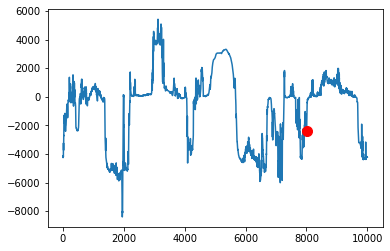

In [10]:
num_new_points = 10000
inew = round(i * num_new_points / (len(h)-1))
xnew = np.linspace(0, len(h)-1, num=num_new_points)
f = interp1d(list(range(len(h))), h)
ynew = f(xnew)
plt.plot(ynew)
plt.plot(
    inew,
    [ynew[inew]],
    marker='o',
    markersize=10,
    color="red"
)
plt.show()

# Output Files

In [11]:
session = boto3.Session(
    aws_access_key_id=os.environ['AWS_ACCESS_KEY'],
    aws_secret_access_key=os.environ['AWS_SECRET_KEY'],
)
client = session.client('s3')

In [ ]:
index = 100
while index < 10801:
    longitude_increment = 0.016666666666666666
    longitude = -180 + longitude_increment * index
    d, l, h, i = get_elevation_path(0, longitude, raster, raster_height, s3_client=client, output_file=True)
    index += 1

Outputting file to s3 for index: 100
Outputting file to s3 for index: 101
Outputting file to s3 for index: 102
Outputting file to s3 for index: 103
Outputting file to s3 for index: 104
Outputting file to s3 for index: 105
Outputting file to s3 for index: 106
Outputting file to s3 for index: 107
Outputting file to s3 for index: 108
Outputting file to s3 for index: 109
Outputting file to s3 for index: 110
Outputting file to s3 for index: 111
Outputting file to s3 for index: 112
Outputting file to s3 for index: 113
Outputting file to s3 for index: 114
Outputting file to s3 for index: 115
Outputting file to s3 for index: 116
Outputting file to s3 for index: 117
Outputting file to s3 for index: 118
Outputting file to s3 for index: 119
Outputting file to s3 for index: 120
Outputting file to s3 for index: 121
Outputting file to s3 for index: 122
Outputting file to s3 for index: 123
Outputting file to s3 for index: 124
Outputting file to s3 for index: 125
Outputting file to s3 for index: 126
O

Outputting file to s3 for index: 322
Outputting file to s3 for index: 323
Outputting file to s3 for index: 324
Outputting file to s3 for index: 325
Outputting file to s3 for index: 326
Outputting file to s3 for index: 327
Outputting file to s3 for index: 328
Outputting file to s3 for index: 329
Outputting file to s3 for index: 330
Outputting file to s3 for index: 331
Outputting file to s3 for index: 332
Outputting file to s3 for index: 333
Outputting file to s3 for index: 334
Outputting file to s3 for index: 335
Outputting file to s3 for index: 336
Outputting file to s3 for index: 337
Outputting file to s3 for index: 338
Outputting file to s3 for index: 339
Outputting file to s3 for index: 340
Outputting file to s3 for index: 341
Outputting file to s3 for index: 342
Outputting file to s3 for index: 343
Outputting file to s3 for index: 344
Outputting file to s3 for index: 345
Outputting file to s3 for index: 346
Outputting file to s3 for index: 347
Outputting file to s3 for index: 348
O

Outputting file to s3 for index: 544
Outputting file to s3 for index: 545
Outputting file to s3 for index: 546
Outputting file to s3 for index: 547
Outputting file to s3 for index: 548
Outputting file to s3 for index: 549
Outputting file to s3 for index: 550
Outputting file to s3 for index: 551
Outputting file to s3 for index: 552
Outputting file to s3 for index: 553
Outputting file to s3 for index: 554
Outputting file to s3 for index: 555
Outputting file to s3 for index: 556
Outputting file to s3 for index: 557
Outputting file to s3 for index: 558
Outputting file to s3 for index: 559
Outputting file to s3 for index: 560
Outputting file to s3 for index: 561
Outputting file to s3 for index: 562
Outputting file to s3 for index: 563
Outputting file to s3 for index: 564
Outputting file to s3 for index: 565
Outputting file to s3 for index: 566
Outputting file to s3 for index: 567
Outputting file to s3 for index: 568
Outputting file to s3 for index: 569
Outputting file to s3 for index: 570
O

Outputting file to s3 for index: 766
Outputting file to s3 for index: 767
Outputting file to s3 for index: 768
Outputting file to s3 for index: 769
Outputting file to s3 for index: 770
Outputting file to s3 for index: 771
Outputting file to s3 for index: 772
Outputting file to s3 for index: 773
Outputting file to s3 for index: 774
Outputting file to s3 for index: 775
Outputting file to s3 for index: 776
Outputting file to s3 for index: 777
Outputting file to s3 for index: 778
Outputting file to s3 for index: 779
Outputting file to s3 for index: 780
Outputting file to s3 for index: 781
Outputting file to s3 for index: 782
Outputting file to s3 for index: 783
Outputting file to s3 for index: 784
Outputting file to s3 for index: 785
Outputting file to s3 for index: 786
Outputting file to s3 for index: 787
Outputting file to s3 for index: 788
Outputting file to s3 for index: 789
Outputting file to s3 for index: 790
Outputting file to s3 for index: 791
Outputting file to s3 for index: 792
O

Outputting file to s3 for index: 988
Outputting file to s3 for index: 989
Outputting file to s3 for index: 990
Outputting file to s3 for index: 991
Outputting file to s3 for index: 992
Outputting file to s3 for index: 993
Outputting file to s3 for index: 994
Outputting file to s3 for index: 995
Outputting file to s3 for index: 996
Outputting file to s3 for index: 997
Outputting file to s3 for index: 998
Outputting file to s3 for index: 999
Outputting file to s3 for index: 1000
Outputting file to s3 for index: 1001
Outputting file to s3 for index: 1002
Outputting file to s3 for index: 1003
Outputting file to s3 for index: 1004
Outputting file to s3 for index: 1005
Outputting file to s3 for index: 1006
Outputting file to s3 for index: 1007
Outputting file to s3 for index: 1008
Outputting file to s3 for index: 1009
Outputting file to s3 for index: 1010
Outputting file to s3 for index: 1011
Outputting file to s3 for index: 1012
Outputting file to s3 for index: 1013
Outputting file to s3 fo

Outputting file to s3 for index: 1204
Outputting file to s3 for index: 1205
Outputting file to s3 for index: 1206
Outputting file to s3 for index: 1207
Outputting file to s3 for index: 1208
Outputting file to s3 for index: 1209
Outputting file to s3 for index: 1210
Outputting file to s3 for index: 1211
Outputting file to s3 for index: 1212
Outputting file to s3 for index: 1213
Outputting file to s3 for index: 1214
Outputting file to s3 for index: 1215
Outputting file to s3 for index: 1216
Outputting file to s3 for index: 1217
Outputting file to s3 for index: 1218
Outputting file to s3 for index: 1219
Outputting file to s3 for index: 1220
Outputting file to s3 for index: 1221
Outputting file to s3 for index: 1222
Outputting file to s3 for index: 1223
Outputting file to s3 for index: 1224
Outputting file to s3 for index: 1225
Outputting file to s3 for index: 1226
Outputting file to s3 for index: 1227
Outputting file to s3 for index: 1228
Outputting file to s3 for index: 1229
Outputting f

Outputting file to s3 for index: 1420
Outputting file to s3 for index: 1421
Outputting file to s3 for index: 1422
Outputting file to s3 for index: 1423
Outputting file to s3 for index: 1424
Outputting file to s3 for index: 1425
Outputting file to s3 for index: 1426
Outputting file to s3 for index: 1427
Outputting file to s3 for index: 1428
Outputting file to s3 for index: 1429
Outputting file to s3 for index: 1430
Outputting file to s3 for index: 1431
Outputting file to s3 for index: 1432
Outputting file to s3 for index: 1433
Outputting file to s3 for index: 1434
Outputting file to s3 for index: 1435
Outputting file to s3 for index: 1436
Outputting file to s3 for index: 1437
Outputting file to s3 for index: 1438
Outputting file to s3 for index: 1439
Outputting file to s3 for index: 1440
Outputting file to s3 for index: 1441
Outputting file to s3 for index: 1442
Outputting file to s3 for index: 1443
Outputting file to s3 for index: 1444
Outputting file to s3 for index: 1445
Outputting f

Outputting file to s3 for index: 1636
Outputting file to s3 for index: 1637
Outputting file to s3 for index: 1638
Outputting file to s3 for index: 1639
Outputting file to s3 for index: 1640
Outputting file to s3 for index: 1641
Outputting file to s3 for index: 1642
Outputting file to s3 for index: 1643
Outputting file to s3 for index: 1644
Outputting file to s3 for index: 1645
Outputting file to s3 for index: 1646
Outputting file to s3 for index: 1647
Outputting file to s3 for index: 1648
Outputting file to s3 for index: 1649
Outputting file to s3 for index: 1650
Outputting file to s3 for index: 1651
Outputting file to s3 for index: 1652
Outputting file to s3 for index: 1653
Outputting file to s3 for index: 1654
Outputting file to s3 for index: 1655
Outputting file to s3 for index: 1656
Outputting file to s3 for index: 1657
Outputting file to s3 for index: 1658
Outputting file to s3 for index: 1659
Outputting file to s3 for index: 1660
Outputting file to s3 for index: 1661
Outputting f

Outputting file to s3 for index: 1852
Outputting file to s3 for index: 1853
Outputting file to s3 for index: 1854
Outputting file to s3 for index: 1855
Outputting file to s3 for index: 1856
Outputting file to s3 for index: 1857
Outputting file to s3 for index: 1858
Outputting file to s3 for index: 1859
Outputting file to s3 for index: 1860
Outputting file to s3 for index: 1861
Outputting file to s3 for index: 1862
Outputting file to s3 for index: 1863
Outputting file to s3 for index: 1864
Outputting file to s3 for index: 1865
Outputting file to s3 for index: 1866
Outputting file to s3 for index: 1867
Outputting file to s3 for index: 1868
Outputting file to s3 for index: 1869
Outputting file to s3 for index: 1870
Outputting file to s3 for index: 1871
Outputting file to s3 for index: 1872
Outputting file to s3 for index: 1873
Outputting file to s3 for index: 1874
Outputting file to s3 for index: 1875
Outputting file to s3 for index: 1876
Outputting file to s3 for index: 1877
Outputting f

Outputting file to s3 for index: 2068
Outputting file to s3 for index: 2069
Outputting file to s3 for index: 2070
Outputting file to s3 for index: 2071
Outputting file to s3 for index: 2072
Outputting file to s3 for index: 2073
Outputting file to s3 for index: 2074
Outputting file to s3 for index: 2075
Outputting file to s3 for index: 2076
Outputting file to s3 for index: 2077
Outputting file to s3 for index: 2078
Outputting file to s3 for index: 2079
Outputting file to s3 for index: 2080
Outputting file to s3 for index: 2081
Outputting file to s3 for index: 2082
Outputting file to s3 for index: 2083
Outputting file to s3 for index: 2084
Outputting file to s3 for index: 2085
Outputting file to s3 for index: 2086
Outputting file to s3 for index: 2087
Outputting file to s3 for index: 2088
Outputting file to s3 for index: 2089
Outputting file to s3 for index: 2090
Outputting file to s3 for index: 2091
Outputting file to s3 for index: 2092
Outputting file to s3 for index: 2093
Outputting f

Outputting file to s3 for index: 2284
Outputting file to s3 for index: 2285
Outputting file to s3 for index: 2286
Outputting file to s3 for index: 2287
Outputting file to s3 for index: 2288
Outputting file to s3 for index: 2289
Outputting file to s3 for index: 2290
Outputting file to s3 for index: 2291
Outputting file to s3 for index: 2292
Outputting file to s3 for index: 2293
Outputting file to s3 for index: 2294
Outputting file to s3 for index: 2295
Outputting file to s3 for index: 2296
Outputting file to s3 for index: 2297
Outputting file to s3 for index: 2298
Outputting file to s3 for index: 2299
Outputting file to s3 for index: 2300
Outputting file to s3 for index: 2301
Outputting file to s3 for index: 2302
Outputting file to s3 for index: 2303
Outputting file to s3 for index: 2304
Outputting file to s3 for index: 2305
Outputting file to s3 for index: 2306
Outputting file to s3 for index: 2307
Outputting file to s3 for index: 2308
Outputting file to s3 for index: 2309
Outputting f

Outputting file to s3 for index: 2500
Outputting file to s3 for index: 2501
Outputting file to s3 for index: 2502
Outputting file to s3 for index: 2503
Outputting file to s3 for index: 2504
Outputting file to s3 for index: 2505
Outputting file to s3 for index: 2506
Outputting file to s3 for index: 2507
Outputting file to s3 for index: 2508
Outputting file to s3 for index: 2509
Outputting file to s3 for index: 2510
Outputting file to s3 for index: 2511
Outputting file to s3 for index: 2512
Outputting file to s3 for index: 2513
Outputting file to s3 for index: 2514
Outputting file to s3 for index: 2515
Outputting file to s3 for index: 2516
Outputting file to s3 for index: 2517
Outputting file to s3 for index: 2518
Outputting file to s3 for index: 2519
Outputting file to s3 for index: 2520
Outputting file to s3 for index: 2521
Outputting file to s3 for index: 2522
Outputting file to s3 for index: 2523
Outputting file to s3 for index: 2524
Outputting file to s3 for index: 2525
Outputting f

Outputting file to s3 for index: 2716
Outputting file to s3 for index: 2717
Outputting file to s3 for index: 2718
Outputting file to s3 for index: 2719
Outputting file to s3 for index: 2720
Outputting file to s3 for index: 2721
Outputting file to s3 for index: 2722
Outputting file to s3 for index: 2723
Outputting file to s3 for index: 2724
Outputting file to s3 for index: 2725
Outputting file to s3 for index: 2726
Outputting file to s3 for index: 2727
Outputting file to s3 for index: 2728
Outputting file to s3 for index: 2729
Outputting file to s3 for index: 2730
Outputting file to s3 for index: 2731
Outputting file to s3 for index: 2732
Outputting file to s3 for index: 2733
Outputting file to s3 for index: 2734
Outputting file to s3 for index: 2735
Outputting file to s3 for index: 2736
Outputting file to s3 for index: 2737
Outputting file to s3 for index: 2738
Outputting file to s3 for index: 2739
Outputting file to s3 for index: 2740
Outputting file to s3 for index: 2741
Outputting f

Outputting file to s3 for index: 2932
Outputting file to s3 for index: 2933
Outputting file to s3 for index: 2934
Outputting file to s3 for index: 2935
Outputting file to s3 for index: 2936
Outputting file to s3 for index: 2937
Outputting file to s3 for index: 2938
Outputting file to s3 for index: 2939
Outputting file to s3 for index: 2940
Outputting file to s3 for index: 2941
Outputting file to s3 for index: 2942
Outputting file to s3 for index: 2943
Outputting file to s3 for index: 2944
Outputting file to s3 for index: 2945
Outputting file to s3 for index: 2946
Outputting file to s3 for index: 2947
Outputting file to s3 for index: 2948
Outputting file to s3 for index: 2949
Outputting file to s3 for index: 2950
Outputting file to s3 for index: 2951
Outputting file to s3 for index: 2952
Outputting file to s3 for index: 2953
Outputting file to s3 for index: 2954
Outputting file to s3 for index: 2955
Outputting file to s3 for index: 2956
Outputting file to s3 for index: 2957
Outputting f

Outputting file to s3 for index: 3148
Outputting file to s3 for index: 3149
Outputting file to s3 for index: 3150
Outputting file to s3 for index: 3151
Outputting file to s3 for index: 3152
Outputting file to s3 for index: 3153
Outputting file to s3 for index: 3154
Outputting file to s3 for index: 3155
Outputting file to s3 for index: 3156
Outputting file to s3 for index: 3157
Outputting file to s3 for index: 3158
Outputting file to s3 for index: 3159
Outputting file to s3 for index: 3160
Outputting file to s3 for index: 3161
Outputting file to s3 for index: 3162
Outputting file to s3 for index: 3163
Outputting file to s3 for index: 3164
Outputting file to s3 for index: 3165
Outputting file to s3 for index: 3166
Outputting file to s3 for index: 3167
Outputting file to s3 for index: 3168
Outputting file to s3 for index: 3169
Outputting file to s3 for index: 3170
Outputting file to s3 for index: 3171
Outputting file to s3 for index: 3172
Outputting file to s3 for index: 3173
Outputting f

Outputting file to s3 for index: 3364
Outputting file to s3 for index: 3365
Outputting file to s3 for index: 3366
Outputting file to s3 for index: 3367
Outputting file to s3 for index: 3368
Outputting file to s3 for index: 3369
Outputting file to s3 for index: 3370
Outputting file to s3 for index: 3371
Outputting file to s3 for index: 3372
Outputting file to s3 for index: 3373
Outputting file to s3 for index: 3374
Outputting file to s3 for index: 3375
Outputting file to s3 for index: 3376
Outputting file to s3 for index: 3377
Outputting file to s3 for index: 3378
Outputting file to s3 for index: 3379
Outputting file to s3 for index: 3380
Outputting file to s3 for index: 3381
Outputting file to s3 for index: 3382
Outputting file to s3 for index: 3383
Outputting file to s3 for index: 3384
Outputting file to s3 for index: 3385
Outputting file to s3 for index: 3386
Outputting file to s3 for index: 3387
Outputting file to s3 for index: 3388
Outputting file to s3 for index: 3389
Outputting f

Outputting file to s3 for index: 3580
Outputting file to s3 for index: 3581
Outputting file to s3 for index: 3582
Outputting file to s3 for index: 3583
Outputting file to s3 for index: 3584
Outputting file to s3 for index: 3585
Outputting file to s3 for index: 3586
Outputting file to s3 for index: 3587
Outputting file to s3 for index: 3588
Outputting file to s3 for index: 3589
Outputting file to s3 for index: 3590
Outputting file to s3 for index: 3591
Outputting file to s3 for index: 3592
Outputting file to s3 for index: 3593
Outputting file to s3 for index: 3594
Outputting file to s3 for index: 3595
Outputting file to s3 for index: 3596
Outputting file to s3 for index: 3597
Outputting file to s3 for index: 3598
Outputting file to s3 for index: 3599
Outputting file to s3 for index: 3600
Outputting file to s3 for index: 3601
Outputting file to s3 for index: 3602
Outputting file to s3 for index: 3603
Outputting file to s3 for index: 3604
Outputting file to s3 for index: 3605
Outputting f

Outputting file to s3 for index: 3796
Outputting file to s3 for index: 3797
Outputting file to s3 for index: 3798
Outputting file to s3 for index: 3799
Outputting file to s3 for index: 3800
Outputting file to s3 for index: 3801
Outputting file to s3 for index: 3802
Outputting file to s3 for index: 3803
Outputting file to s3 for index: 3804
Outputting file to s3 for index: 3805
Outputting file to s3 for index: 3806
Outputting file to s3 for index: 3807
Outputting file to s3 for index: 3808
Outputting file to s3 for index: 3809
Outputting file to s3 for index: 3810
Outputting file to s3 for index: 3811
Outputting file to s3 for index: 3812
Outputting file to s3 for index: 3813
Outputting file to s3 for index: 3814
Outputting file to s3 for index: 3815
Outputting file to s3 for index: 3816
Outputting file to s3 for index: 3817
Outputting file to s3 for index: 3818
Outputting file to s3 for index: 3819
Outputting file to s3 for index: 3820
Outputting file to s3 for index: 3821
Outputting f

Outputting file to s3 for index: 4012
Outputting file to s3 for index: 4013
Outputting file to s3 for index: 4014
Outputting file to s3 for index: 4015
Outputting file to s3 for index: 4016
Outputting file to s3 for index: 4017
Outputting file to s3 for index: 4018
Outputting file to s3 for index: 4019
Outputting file to s3 for index: 4020
Outputting file to s3 for index: 4021
Outputting file to s3 for index: 4022
Outputting file to s3 for index: 4023
Outputting file to s3 for index: 4024
Outputting file to s3 for index: 4025
Outputting file to s3 for index: 4026
Outputting file to s3 for index: 4027
Outputting file to s3 for index: 4028
Outputting file to s3 for index: 4029
Outputting file to s3 for index: 4030
Outputting file to s3 for index: 4031
Outputting file to s3 for index: 4032
Outputting file to s3 for index: 4033
Outputting file to s3 for index: 4034
Outputting file to s3 for index: 4035
Outputting file to s3 for index: 4036
Outputting file to s3 for index: 4037
Outputting f

Outputting file to s3 for index: 4228
Outputting file to s3 for index: 4229
Outputting file to s3 for index: 4230
Outputting file to s3 for index: 4231
Outputting file to s3 for index: 4232
Outputting file to s3 for index: 4233
Outputting file to s3 for index: 4234
Outputting file to s3 for index: 4235
Outputting file to s3 for index: 4236
Outputting file to s3 for index: 4237
Outputting file to s3 for index: 4238
Outputting file to s3 for index: 4239
Outputting file to s3 for index: 4240
Outputting file to s3 for index: 4241
Outputting file to s3 for index: 4242
Outputting file to s3 for index: 4243
Outputting file to s3 for index: 4244
Outputting file to s3 for index: 4245
Outputting file to s3 for index: 4246
Outputting file to s3 for index: 4247
Outputting file to s3 for index: 4248
Outputting file to s3 for index: 4249
Outputting file to s3 for index: 4250
Outputting file to s3 for index: 4251
Outputting file to s3 for index: 4252
Outputting file to s3 for index: 4253
Outputting f

Outputting file to s3 for index: 4444
Outputting file to s3 for index: 4445
Outputting file to s3 for index: 4446
Outputting file to s3 for index: 4447
Outputting file to s3 for index: 4448
Outputting file to s3 for index: 4449
Outputting file to s3 for index: 4450
Outputting file to s3 for index: 4451
Outputting file to s3 for index: 4452
Outputting file to s3 for index: 4453
Outputting file to s3 for index: 4454
Outputting file to s3 for index: 4455
Outputting file to s3 for index: 4456
Outputting file to s3 for index: 4457
Outputting file to s3 for index: 4458
Outputting file to s3 for index: 4459
Outputting file to s3 for index: 4460
Outputting file to s3 for index: 4461
Outputting file to s3 for index: 4462
Outputting file to s3 for index: 4463
Outputting file to s3 for index: 4464
Outputting file to s3 for index: 4465
Outputting file to s3 for index: 4466
Outputting file to s3 for index: 4467
Outputting file to s3 for index: 4468
Outputting file to s3 for index: 4469
Outputting f

Outputting file to s3 for index: 4660
Outputting file to s3 for index: 4661
Outputting file to s3 for index: 4662
Outputting file to s3 for index: 4663
Outputting file to s3 for index: 4664
Outputting file to s3 for index: 4665
Outputting file to s3 for index: 4666
Outputting file to s3 for index: 4667
Outputting file to s3 for index: 4668
Outputting file to s3 for index: 4669
Outputting file to s3 for index: 4670
Outputting file to s3 for index: 4671
Outputting file to s3 for index: 4672
Outputting file to s3 for index: 4673
Outputting file to s3 for index: 4674
Outputting file to s3 for index: 4675
Outputting file to s3 for index: 4676
Outputting file to s3 for index: 4677
Outputting file to s3 for index: 4678
Outputting file to s3 for index: 4679
Outputting file to s3 for index: 4680
Outputting file to s3 for index: 4681
Outputting file to s3 for index: 4682
Outputting file to s3 for index: 4683
Outputting file to s3 for index: 4684
Outputting file to s3 for index: 4685
Outputting f

Outputting file to s3 for index: 4876
Outputting file to s3 for index: 4877
Outputting file to s3 for index: 4878
Outputting file to s3 for index: 4879
Outputting file to s3 for index: 4880
Outputting file to s3 for index: 4881
Outputting file to s3 for index: 4882
Outputting file to s3 for index: 4883
Outputting file to s3 for index: 4884
Outputting file to s3 for index: 4885
Outputting file to s3 for index: 4886
Outputting file to s3 for index: 4887
Outputting file to s3 for index: 4888
Outputting file to s3 for index: 4889
Outputting file to s3 for index: 4890
Outputting file to s3 for index: 4891
Outputting file to s3 for index: 4892
Outputting file to s3 for index: 4893
Outputting file to s3 for index: 4894
Outputting file to s3 for index: 4895
Outputting file to s3 for index: 4896
Outputting file to s3 for index: 4897
Outputting file to s3 for index: 4898
Outputting file to s3 for index: 4899
Outputting file to s3 for index: 4900
Outputting file to s3 for index: 4901
Outputting f

Outputting file to s3 for index: 5092
Outputting file to s3 for index: 5093
Outputting file to s3 for index: 5094
Outputting file to s3 for index: 5095
Outputting file to s3 for index: 5096
Outputting file to s3 for index: 5097
Outputting file to s3 for index: 5098
Outputting file to s3 for index: 5099
Outputting file to s3 for index: 5100
Outputting file to s3 for index: 5101
Outputting file to s3 for index: 5102
Outputting file to s3 for index: 5103
Outputting file to s3 for index: 5104
Outputting file to s3 for index: 5105
Outputting file to s3 for index: 5106
Outputting file to s3 for index: 5107
Outputting file to s3 for index: 5108
Outputting file to s3 for index: 5109
Outputting file to s3 for index: 5110
Outputting file to s3 for index: 5111
Outputting file to s3 for index: 5112
Outputting file to s3 for index: 5113
Outputting file to s3 for index: 5114
Outputting file to s3 for index: 5115
Outputting file to s3 for index: 5116
Outputting file to s3 for index: 5117
Outputting f

Outputting file to s3 for index: 5308
Outputting file to s3 for index: 5309
Outputting file to s3 for index: 5310
Outputting file to s3 for index: 5311
Outputting file to s3 for index: 5312
Outputting file to s3 for index: 5313
Outputting file to s3 for index: 5314
Outputting file to s3 for index: 5315
Outputting file to s3 for index: 5316
Outputting file to s3 for index: 5317
Outputting file to s3 for index: 5318
Outputting file to s3 for index: 5319
Outputting file to s3 for index: 5320
Outputting file to s3 for index: 5321
Outputting file to s3 for index: 5322
Outputting file to s3 for index: 5323
Outputting file to s3 for index: 5324
Outputting file to s3 for index: 5325
Outputting file to s3 for index: 5326
Outputting file to s3 for index: 5327
Outputting file to s3 for index: 5328
Outputting file to s3 for index: 5329
Outputting file to s3 for index: 5330
Outputting file to s3 for index: 5331
Outputting file to s3 for index: 5332
Outputting file to s3 for index: 5333
Outputting f

Outputting file to s3 for index: 5524
Outputting file to s3 for index: 5525
Outputting file to s3 for index: 5526
Outputting file to s3 for index: 5527
Outputting file to s3 for index: 5528
Outputting file to s3 for index: 5529
Outputting file to s3 for index: 5530
Outputting file to s3 for index: 5531
Outputting file to s3 for index: 5532
Outputting file to s3 for index: 5533
Outputting file to s3 for index: 5534
Outputting file to s3 for index: 5535
Outputting file to s3 for index: 5536
Outputting file to s3 for index: 5537
Outputting file to s3 for index: 5538
Outputting file to s3 for index: 5539
Outputting file to s3 for index: 5540
Outputting file to s3 for index: 5541
Outputting file to s3 for index: 5542
Outputting file to s3 for index: 5543
Outputting file to s3 for index: 5544
Outputting file to s3 for index: 5545
Outputting file to s3 for index: 5546
Outputting file to s3 for index: 5547
Outputting file to s3 for index: 5548
Outputting file to s3 for index: 5549
Outputting f

Outputting file to s3 for index: 5740
Outputting file to s3 for index: 5741
Outputting file to s3 for index: 5742
Outputting file to s3 for index: 5743
Outputting file to s3 for index: 5744
Outputting file to s3 for index: 5745
Outputting file to s3 for index: 5746
Outputting file to s3 for index: 5747
Outputting file to s3 for index: 5748
Outputting file to s3 for index: 5749
Outputting file to s3 for index: 5750
Outputting file to s3 for index: 5751
Outputting file to s3 for index: 5752
Outputting file to s3 for index: 5753
Outputting file to s3 for index: 5754
Outputting file to s3 for index: 5755
Outputting file to s3 for index: 5756
Outputting file to s3 for index: 5757
Outputting file to s3 for index: 5758
Outputting file to s3 for index: 5759
Outputting file to s3 for index: 5760
Outputting file to s3 for index: 5761
Outputting file to s3 for index: 5762
Outputting file to s3 for index: 5763
Outputting file to s3 for index: 5764
Outputting file to s3 for index: 5765
Outputting f

Outputting file to s3 for index: 5956
Outputting file to s3 for index: 5957
Outputting file to s3 for index: 5958
Outputting file to s3 for index: 5959
Outputting file to s3 for index: 5960
Outputting file to s3 for index: 5961
Outputting file to s3 for index: 5962
Outputting file to s3 for index: 5963
Outputting file to s3 for index: 5964
Outputting file to s3 for index: 5965
Outputting file to s3 for index: 5966
Outputting file to s3 for index: 5967
Outputting file to s3 for index: 5968
Outputting file to s3 for index: 5969
Outputting file to s3 for index: 5970
Outputting file to s3 for index: 5971
Outputting file to s3 for index: 5972
Outputting file to s3 for index: 5973
Outputting file to s3 for index: 5974
Outputting file to s3 for index: 5975
Outputting file to s3 for index: 5976
Outputting file to s3 for index: 5977
Outputting file to s3 for index: 5978
Outputting file to s3 for index: 5979
Outputting file to s3 for index: 5980
Outputting file to s3 for index: 5981
Outputting f

Outputting file to s3 for index: 6172
Outputting file to s3 for index: 6173
Outputting file to s3 for index: 6174
Outputting file to s3 for index: 6175
Outputting file to s3 for index: 6176
Outputting file to s3 for index: 6177
Outputting file to s3 for index: 6178
Outputting file to s3 for index: 6179
Outputting file to s3 for index: 6180
Outputting file to s3 for index: 6181
Outputting file to s3 for index: 6182
Outputting file to s3 for index: 6183
Outputting file to s3 for index: 6184
Outputting file to s3 for index: 6185
Outputting file to s3 for index: 6186
Outputting file to s3 for index: 6187
Outputting file to s3 for index: 6188
Outputting file to s3 for index: 6189
Outputting file to s3 for index: 6190
Outputting file to s3 for index: 6191
Outputting file to s3 for index: 6192
Outputting file to s3 for index: 6193
Outputting file to s3 for index: 6194
Outputting file to s3 for index: 6195
Outputting file to s3 for index: 6196
Outputting file to s3 for index: 6197
Outputting f

Outputting file to s3 for index: 6388
Outputting file to s3 for index: 6389
Outputting file to s3 for index: 6390
Outputting file to s3 for index: 6391
Outputting file to s3 for index: 6392
Outputting file to s3 for index: 6393
Outputting file to s3 for index: 6394
Outputting file to s3 for index: 6395
Outputting file to s3 for index: 6396
Outputting file to s3 for index: 6397
Outputting file to s3 for index: 6398
Outputting file to s3 for index: 6399
Outputting file to s3 for index: 6400
Outputting file to s3 for index: 6401
Outputting file to s3 for index: 6402
Outputting file to s3 for index: 6403
Outputting file to s3 for index: 6404
Outputting file to s3 for index: 6405
Outputting file to s3 for index: 6406
Outputting file to s3 for index: 6407
Outputting file to s3 for index: 6408
Outputting file to s3 for index: 6409
Outputting file to s3 for index: 6410
Outputting file to s3 for index: 6411
Outputting file to s3 for index: 6412
Outputting file to s3 for index: 6413
Outputting f

Outputting file to s3 for index: 6604
Outputting file to s3 for index: 6605
Outputting file to s3 for index: 6606
Outputting file to s3 for index: 6607
Outputting file to s3 for index: 6608
Outputting file to s3 for index: 6609
Outputting file to s3 for index: 6610
Outputting file to s3 for index: 6611
Outputting file to s3 for index: 6612
Outputting file to s3 for index: 6613
Outputting file to s3 for index: 6614
Outputting file to s3 for index: 6615
Outputting file to s3 for index: 6616
Outputting file to s3 for index: 6617
Outputting file to s3 for index: 6618
Outputting file to s3 for index: 6619
Outputting file to s3 for index: 6620
Outputting file to s3 for index: 6621
Outputting file to s3 for index: 6622
Outputting file to s3 for index: 6623
Outputting file to s3 for index: 6624
Outputting file to s3 for index: 6625
Outputting file to s3 for index: 6626
Outputting file to s3 for index: 6627
Outputting file to s3 for index: 6628
Outputting file to s3 for index: 6629
Outputting f

Outputting file to s3 for index: 6820
Outputting file to s3 for index: 6821
Outputting file to s3 for index: 6822
Outputting file to s3 for index: 6823
Outputting file to s3 for index: 6824
Outputting file to s3 for index: 6825
Outputting file to s3 for index: 6826
Outputting file to s3 for index: 6827
Outputting file to s3 for index: 6828
Outputting file to s3 for index: 6829
Outputting file to s3 for index: 6830
Outputting file to s3 for index: 6831
Outputting file to s3 for index: 6832
Outputting file to s3 for index: 6833
Outputting file to s3 for index: 6834
Outputting file to s3 for index: 6835
Outputting file to s3 for index: 6836
Outputting file to s3 for index: 6837
Outputting file to s3 for index: 6838
Outputting file to s3 for index: 6839
Outputting file to s3 for index: 6840
Outputting file to s3 for index: 6841
Outputting file to s3 for index: 6842
Outputting file to s3 for index: 6843
Outputting file to s3 for index: 6844
Outputting file to s3 for index: 6845
Outputting f

Outputting file to s3 for index: 7036
Outputting file to s3 for index: 7037
Outputting file to s3 for index: 7038
Outputting file to s3 for index: 7039
Outputting file to s3 for index: 7040
Outputting file to s3 for index: 7041
Outputting file to s3 for index: 7042
Outputting file to s3 for index: 7043
Outputting file to s3 for index: 7044
Outputting file to s3 for index: 7045
Outputting file to s3 for index: 7046
Outputting file to s3 for index: 7047
Outputting file to s3 for index: 7048
Outputting file to s3 for index: 7049
Outputting file to s3 for index: 7050
Outputting file to s3 for index: 7051
Outputting file to s3 for index: 7052
Outputting file to s3 for index: 7053
Outputting file to s3 for index: 7054
Outputting file to s3 for index: 7055
Outputting file to s3 for index: 7056
Outputting file to s3 for index: 7057
Outputting file to s3 for index: 7058
Outputting file to s3 for index: 7059
Outputting file to s3 for index: 7060
Outputting file to s3 for index: 7061
Outputting f

Outputting file to s3 for index: 7252
Outputting file to s3 for index: 7253
Outputting file to s3 for index: 7254
Outputting file to s3 for index: 7255
Outputting file to s3 for index: 7256
Outputting file to s3 for index: 7257
Outputting file to s3 for index: 7258
Outputting file to s3 for index: 7259
Outputting file to s3 for index: 7260
Outputting file to s3 for index: 7261
Outputting file to s3 for index: 7262
Outputting file to s3 for index: 7263
Outputting file to s3 for index: 7264
Outputting file to s3 for index: 7265
Outputting file to s3 for index: 7266
Outputting file to s3 for index: 7267
Outputting file to s3 for index: 7268
Outputting file to s3 for index: 7269
Outputting file to s3 for index: 7270
Outputting file to s3 for index: 7271
Outputting file to s3 for index: 7272
Outputting file to s3 for index: 7273
Outputting file to s3 for index: 7274
Outputting file to s3 for index: 7275
Outputting file to s3 for index: 7276
Outputting file to s3 for index: 7277
Outputting f

Outputting file to s3 for index: 7468
Outputting file to s3 for index: 7469
Outputting file to s3 for index: 7470
Outputting file to s3 for index: 7471
Outputting file to s3 for index: 7472
Outputting file to s3 for index: 7473
Outputting file to s3 for index: 7474
Outputting file to s3 for index: 7475
Outputting file to s3 for index: 7476
Outputting file to s3 for index: 7477
Outputting file to s3 for index: 7478
Outputting file to s3 for index: 7479
Outputting file to s3 for index: 7480
Outputting file to s3 for index: 7481
Outputting file to s3 for index: 7482
Outputting file to s3 for index: 7483
Outputting file to s3 for index: 7484
Outputting file to s3 for index: 7485
Outputting file to s3 for index: 7486
Outputting file to s3 for index: 7487
Outputting file to s3 for index: 7488
Outputting file to s3 for index: 7489
Outputting file to s3 for index: 7490
Outputting file to s3 for index: 7491
Outputting file to s3 for index: 7492
Outputting file to s3 for index: 7493
Outputting f

Outputting file to s3 for index: 7684
Outputting file to s3 for index: 7685
Outputting file to s3 for index: 7686
Outputting file to s3 for index: 7687
Outputting file to s3 for index: 7688
Outputting file to s3 for index: 7689
Outputting file to s3 for index: 7690
Outputting file to s3 for index: 7691
Outputting file to s3 for index: 7692
Outputting file to s3 for index: 7693
Outputting file to s3 for index: 7694
Outputting file to s3 for index: 7695
Outputting file to s3 for index: 7696
Outputting file to s3 for index: 7697
Outputting file to s3 for index: 7698
Outputting file to s3 for index: 7699
Outputting file to s3 for index: 7700
Outputting file to s3 for index: 7701
Outputting file to s3 for index: 7702
Outputting file to s3 for index: 7703
Outputting file to s3 for index: 7704
Outputting file to s3 for index: 7705
Outputting file to s3 for index: 7706
Outputting file to s3 for index: 7707
Outputting file to s3 for index: 7708
Outputting file to s3 for index: 7709
Outputting f

Outputting file to s3 for index: 7900
Outputting file to s3 for index: 7901
Outputting file to s3 for index: 7902
Outputting file to s3 for index: 7903
Outputting file to s3 for index: 7904
Outputting file to s3 for index: 7905
Outputting file to s3 for index: 7906
Outputting file to s3 for index: 7907
Outputting file to s3 for index: 7908
Outputting file to s3 for index: 7909
Outputting file to s3 for index: 7910
Outputting file to s3 for index: 7911
Outputting file to s3 for index: 7912
Outputting file to s3 for index: 7913
Outputting file to s3 for index: 7914
Outputting file to s3 for index: 7915
Outputting file to s3 for index: 7916
Outputting file to s3 for index: 7917
Outputting file to s3 for index: 7918
Outputting file to s3 for index: 7919
Outputting file to s3 for index: 7920
Outputting file to s3 for index: 7921
Outputting file to s3 for index: 7922
Outputting file to s3 for index: 7923
Outputting file to s3 for index: 7924
Outputting file to s3 for index: 7925
Outputting f

Outputting file to s3 for index: 8116
Outputting file to s3 for index: 8117
Outputting file to s3 for index: 8118
Outputting file to s3 for index: 8119
Outputting file to s3 for index: 8120
Outputting file to s3 for index: 8121
Outputting file to s3 for index: 8122
Outputting file to s3 for index: 8123
Outputting file to s3 for index: 8124
Outputting file to s3 for index: 8125
Outputting file to s3 for index: 8126
Outputting file to s3 for index: 8127
Outputting file to s3 for index: 8128
Outputting file to s3 for index: 8129
Outputting file to s3 for index: 8130
Outputting file to s3 for index: 8131
Outputting file to s3 for index: 8132
Outputting file to s3 for index: 8133
Outputting file to s3 for index: 8134
Outputting file to s3 for index: 8135
Outputting file to s3 for index: 8136
Outputting file to s3 for index: 8137
Outputting file to s3 for index: 8138
Outputting file to s3 for index: 8139
Outputting file to s3 for index: 8140
Outputting file to s3 for index: 8141
Outputting f

Outputting file to s3 for index: 8332
Outputting file to s3 for index: 8333
Outputting file to s3 for index: 8334
Outputting file to s3 for index: 8335
Outputting file to s3 for index: 8336
Outputting file to s3 for index: 8337
Outputting file to s3 for index: 8338
Outputting file to s3 for index: 8339
Outputting file to s3 for index: 8340
Outputting file to s3 for index: 8341
Outputting file to s3 for index: 8342
Outputting file to s3 for index: 8343
Outputting file to s3 for index: 8344
Outputting file to s3 for index: 8345
Outputting file to s3 for index: 8346
Outputting file to s3 for index: 8347
Outputting file to s3 for index: 8348
Outputting file to s3 for index: 8349
Outputting file to s3 for index: 8350
Outputting file to s3 for index: 8351
Outputting file to s3 for index: 8352
Outputting file to s3 for index: 8353
Outputting file to s3 for index: 8354
Outputting file to s3 for index: 8355
Outputting file to s3 for index: 8356
Outputting file to s3 for index: 8357
Outputting f

Outputting file to s3 for index: 8548
Outputting file to s3 for index: 8549
Outputting file to s3 for index: 8550
Outputting file to s3 for index: 8551
Outputting file to s3 for index: 8552
Outputting file to s3 for index: 8553
Outputting file to s3 for index: 8554
Outputting file to s3 for index: 8555
Outputting file to s3 for index: 8556
Outputting file to s3 for index: 8557
Outputting file to s3 for index: 8558
Outputting file to s3 for index: 8559
Outputting file to s3 for index: 8560
Outputting file to s3 for index: 8561
Outputting file to s3 for index: 8562
Outputting file to s3 for index: 8563
Outputting file to s3 for index: 8564
Outputting file to s3 for index: 8565
Outputting file to s3 for index: 8566
Outputting file to s3 for index: 8567
Outputting file to s3 for index: 8568
Outputting file to s3 for index: 8569
Outputting file to s3 for index: 8570
Outputting file to s3 for index: 8571
Outputting file to s3 for index: 8572
Outputting file to s3 for index: 8573
Outputting f

Outputting file to s3 for index: 8764
Outputting file to s3 for index: 8765
Outputting file to s3 for index: 8766
Outputting file to s3 for index: 8767
Outputting file to s3 for index: 8768
Outputting file to s3 for index: 8769
Outputting file to s3 for index: 8770
Outputting file to s3 for index: 8771
Outputting file to s3 for index: 8772
Outputting file to s3 for index: 8773
Outputting file to s3 for index: 8774
Outputting file to s3 for index: 8775
Outputting file to s3 for index: 8776
Outputting file to s3 for index: 8777
Outputting file to s3 for index: 8778
Outputting file to s3 for index: 8779
Outputting file to s3 for index: 8780
Outputting file to s3 for index: 8781
Outputting file to s3 for index: 8782
Outputting file to s3 for index: 8783
Outputting file to s3 for index: 8784
Outputting file to s3 for index: 8785
Outputting file to s3 for index: 8786
Outputting file to s3 for index: 8787
Outputting file to s3 for index: 8788
Outputting file to s3 for index: 8789
Outputting f